### Задание
В наших данных использования ленты новостей есть два типа юзеров: те, кто пришел через платный трафик source = 'ads', и те, кто пришел через органические каналы source = 'organic'.

Ваша задача — проанализировать и сравнить Retention этих двух групп пользователей. Решением этой задачи будет ответ на вопрос: отличается ли характер использования приложения у этих групп пользователей. 

In [1]:
# Подгружаем библиотеки
import pandas as pd
import numpy as np
import pandahouse
import datetime as dt
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
%matplotlib inline

plt.style.use('seaborn-whitegrid')

sns.set(font_scale = 1.25,
        style = 'whitegrid',
        rc = {'figure.figsize': (14, 3)})

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

---

In [3]:
# Выгрузим данные всех юзеров, которые пришли в приложение в течении последнего 21 дня.
query = '''select * 
from 
    (select 
        user_id, 
        toDate(time) as time_of_action,
        source
    from simulator_20221020.feed_actions) as l
inner join 
    (select 
        user_id,
        toDate(min(time)) as first_visit
    from simulator_20221020.feed_actions
    group by user_id) as r
using user_id
where first_visit >= today() - 21
order by user_id, time_of_action'''

In [4]:
df = pandahouse.read_clickhouse(query, connection = connection)

In [5]:
df.head(3)

,user_id,time_of_action,source,first_visit
0,5346,2022-10-28,ads,2022-10-28
1,5346,2022-10-28,ads,2022-10-28
2,5346,2022-10-28,ads,2022-10-28


In [6]:
df.shape

(6223343, 4)

In [7]:
# Создадим колонку с разницей во времени между первым визитом и действием в приложении
df['day_after'] = (df.time_of_action - df.first_visit).dt.days

In [8]:
df.head(3)

,user_id,time_of_action,source,first_visit,day_after
0,5346,2022-10-28,ads,2022-10-28,0
1,5346,2022-10-28,ads,2022-10-28,0
2,5346,2022-10-28,ads,2022-10-28,0


In [9]:
# Разделим юзеров по источнику трафика
df_ads = df.query('source == "ads"')[['user_id', 'first_visit', 'day_after']]
df_organic = df.query('source == "organic"')[['user_id', 'first_visit', 'day_after']]

In [10]:
def cohort_analysis(df):
    """
    Данная функция принимает датафрейм с 3 колонками (user_id, first_visit, day_after)
    и возвращает датафреймы с результатами когортного анализа(в процентах и абсолютных значениях),
    а также выводит на печать тепловую карту для когортного анализа.
    """
    
    # Группируем по когорте и периодом времени между первым визитом и действием, агрегируем по уникальным id
    df_ads_grouped = df.groupby(['first_visit', 'day_after'], as_index = False).agg({'user_id': pd.Series.nunique}) \
        .sort_values(['first_visit', 'day_after'])
    
    df_ads_grouped['first_visit'] = df_ads_grouped['first_visit'].dt.date
    
    # Делаем сводную таблицу
    cohort_count = df_ads_grouped.pivot_table(index = 'first_visit', columns = 'day_after', values = 'user_id')
    
    # Переводим retention в проценты
    cohort_size = cohort_count.iloc[:, 0]
    retention = cohort_count.divide(cohort_size, axis = 0)
    
    # Визуализируем
    plt.figure(figsize = (26, 12))
    plt.title('Cohort Analysis - Retention Rate')
    sns.heatmap(data = retention, 
                annot = True, 
                fmt = '.0%', 
                vmin = 0.0,
                vmax = 0.5,
                cmap = "YlGnBu")
    plt.xlabel('Day of return', fontsize = 14)
    plt.ylabel('Date of first visit', fontsize = 14)
    
    plt.show()
    
    return([retention, cohort_count])

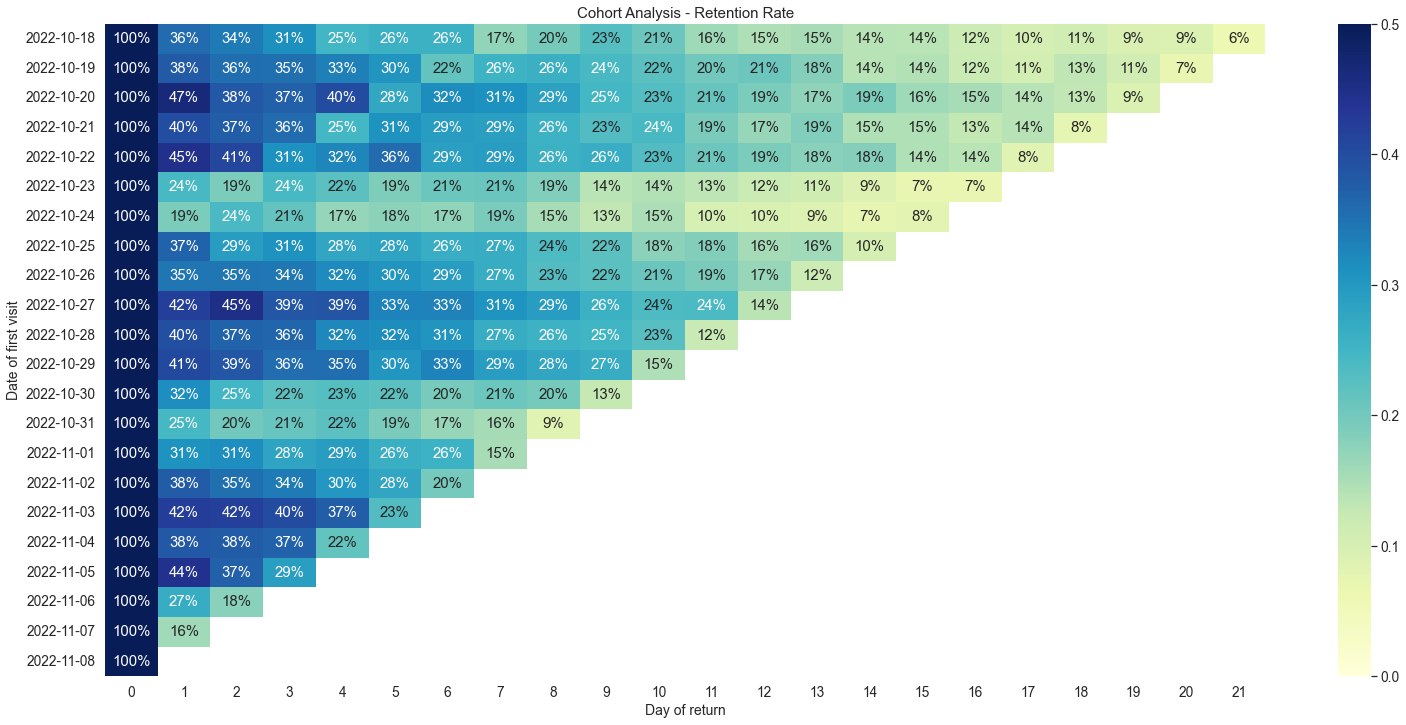

In [11]:
# Применим функцию для юзеров пришедших черех рекламный трафик
ret_ads = cohort_analysis(df_ads)

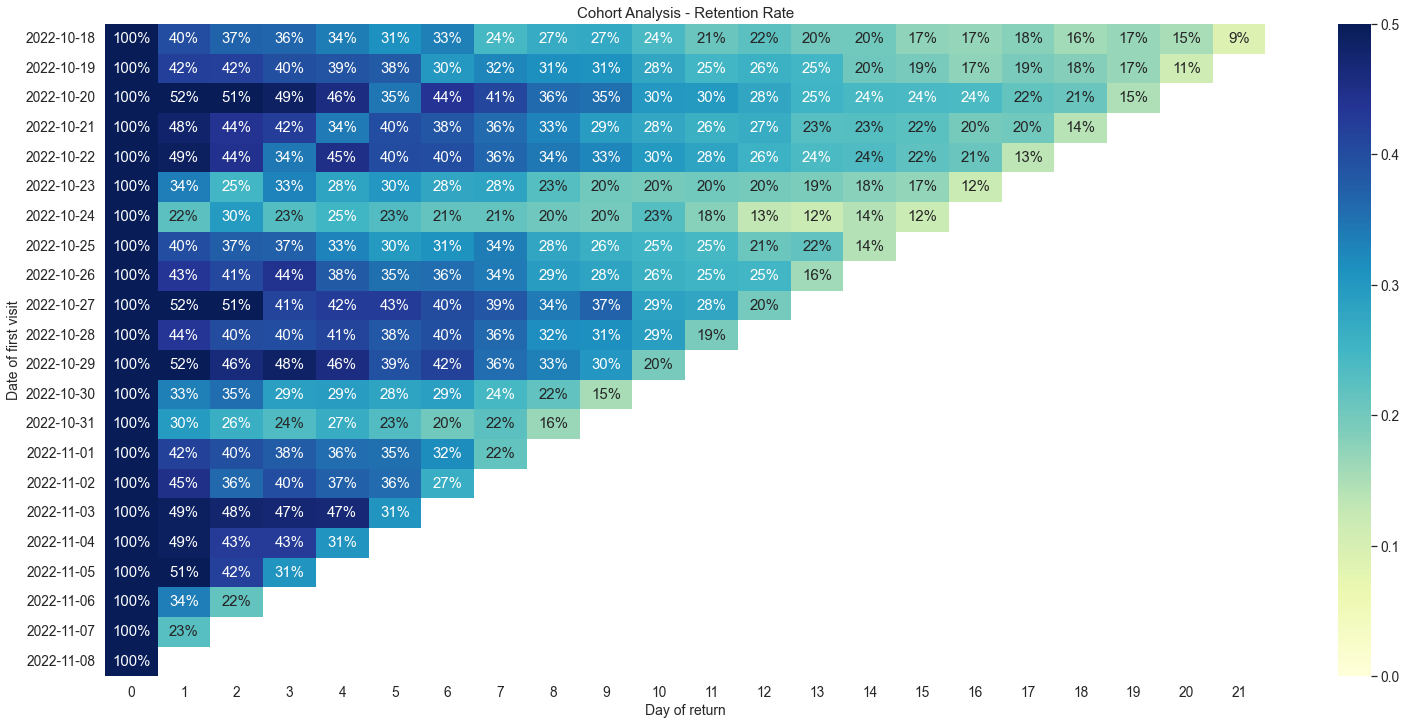

In [12]:
# Применим функцию для юзеров пришедших черех органический трафик
ret_organic = cohort_analysis(df_organic)

Если сравнивать хитмапы для рекламного и органического трафика то становится видно, что ритеншн стабильно выше у органического трафика.
Для наглядности сравним разницу в абсолютных значениях:

In [13]:
difference = ret_organic[0] - ret_ads[0]

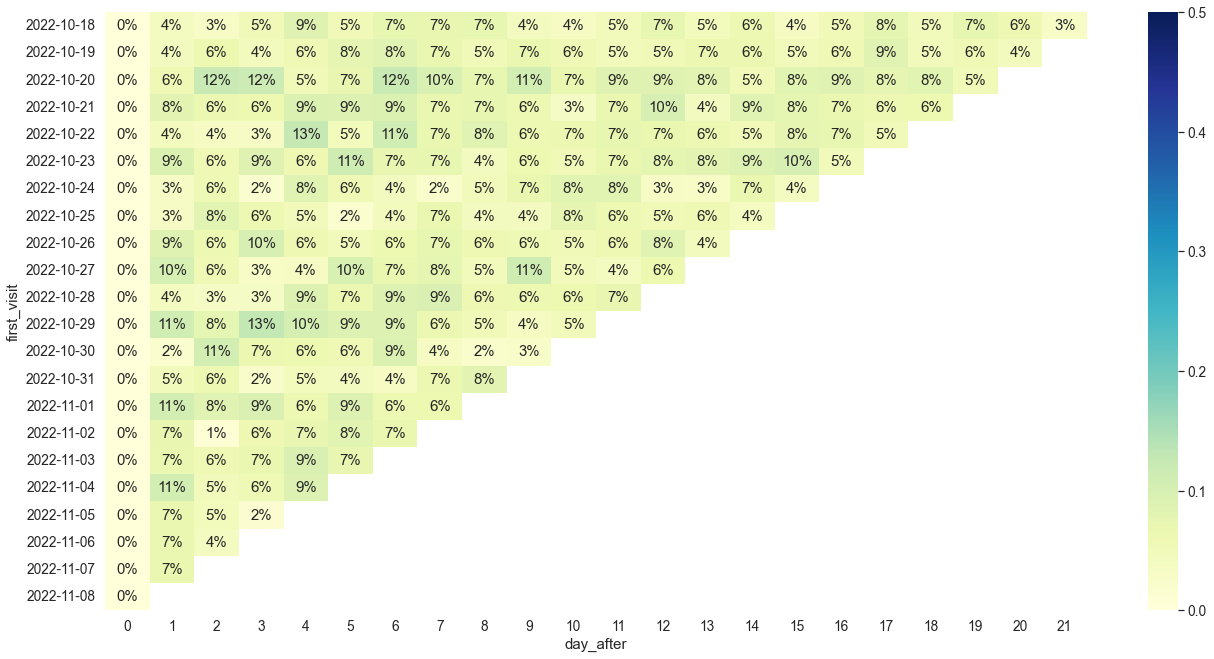

In [14]:
plt.figure(figsize = (22, 11))
plt.title('')
sns.heatmap(data = difference, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.5,
            cmap = "YlGnBu")
plt.show()

Для сравнения мы также можем использовать метрику Lifetime, которая показывает, сколько в среднем пользователь активен в проекте. Для этого достаточно сложить все значения ритеншена для каждой когорты отдельно:

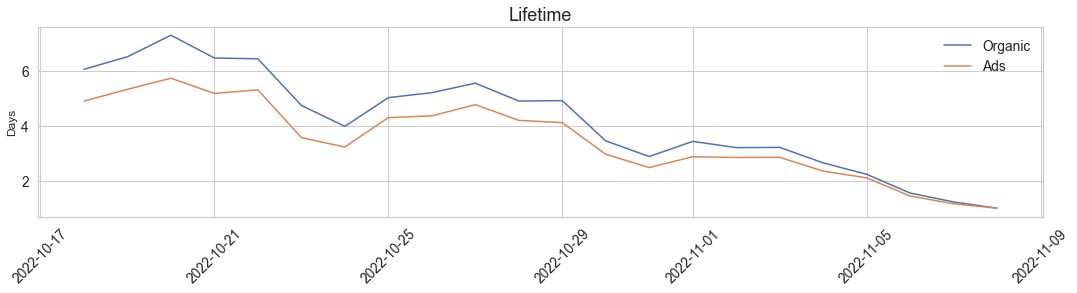

In [15]:
organic_lt = ret_organic[0].apply(np.sum, axis = 1)
ads_lt = ret_ads[0].apply(np.sum, axis = 1)

plt.plot(organic_lt.index, organic_lt.values)
plt.plot(ads_lt.index, ads_lt.values)
plt.title('Lifetime', fontsize = 18)
plt.legend(['Organic', 'Ads'])
plt.xticks(rotation = 45)
plt.gcf().set_size_inches(18, 3.5)
plt.ylabel('Days', fontsize = 12)
plt.show()

Различия в Lifetime и ритеншене очевидны, но не понятно, являются ли такие различия статистически значимыми. 

Интересно, как это можно проверить? 
Мне такие способы не известны, к сожалению :( Но я подумал и пришел к тому, что тут можно использовать тест пропорций, потому что процент ритеншена в каждый из n-ых дней представляет собой конверсию в возвращение. То есть, предположим, для когорты 2022-10-08 органики конверсия в 10-ый день 20%, а для той же когорты рекламного трафика - 10%. При этом, нам известен размер выборки - кол-во уникальных новых пользователей в 0-ой день для соответствующей когорты в рекламе и органике. И если тестом пропорций сравнивать доли вернувшихся пользователей на 10-ый день, то p-value будет означать вер-сть получить такие или еще более сильные различия в пропорциях случайным образом.

Сравним данные для каждой когорты тестом пропорций:

In [16]:
def z_proportions_for_retention(ret_ads, ret_organic):

    """
    Данная функция принимает результат функции cohort_analysis
    и возвращает датафрейм со значениями p-value для каждой сравниваемой ячейки,
    а также выводит на печать тепловую карту со значениями p-value для каждой сравниваемой ячейки.
    """
    
    # тут сохраняем даты для когорт
    index_names = ret_ads[0].index
    
    # тут сохраняем кол-во уникальных пользователей в 0-ой день для каждой когорты
    ads_zero_day = ret_ads[1].iloc[:, 0].values
    organic_zero_day = ret_organic[1].iloc[:, 0].values
    
    # тут отрезаем кол-во уникальных пользователей в 0-ой день для каждой когорты
    ret_ads = ret_ads[1].iloc[:, 1:]
    ret_organic = ret_organic[1].iloc[:, 1:]
    
    # создадим пустой датафрейм, в который будем записывать рез-ты
    result = pd.DataFrame(columns = ret_ads.columns) 
    demanded_columns = len(ret_ads.columns)

    # реализация теста пропорций
    for row in range(len(ret_ads)):

        new_column = [] # сюда запишем p_values

        for column in range(len(ret_ads.iloc[row, 0:].dropna())):
            
            stat, pval = proportions_ztest(np.array([ret_organic.iloc[row, column], ret_ads.iloc[row, column]]),
                                  np.array([organic_zero_day[row], ads_zero_day[row]]), alternative = 'larger')
            
            new_column.append(round(float(pval), 3))
        
        # nan's нужны чтобы все вставить в датафрейм
        amount_of_na = (demanded_columns - len(new_column))
        nas = [np.nan] * amount_of_na
        new_column = new_column + nas
        
        # вставляем в датафрейм
        result.loc[len(result)] = new_column
     
    # вернем когортам имена
    result.index = index_names
    
    # нарисуем
    plt.figure(figsize = (26, 12))
    plt.title('Cohort Analysis', fontsize=18)
    sns.heatmap(data = result, annot = True, 
                vmin = 0.0, vmax = 0.5, cmap = "YlGnBu")
    plt.xlabel('Day of return', fontsize = 14)
    plt.ylabel('Date of first visit', fontsize = 14)
    
    plt.show()
    
    return(result)

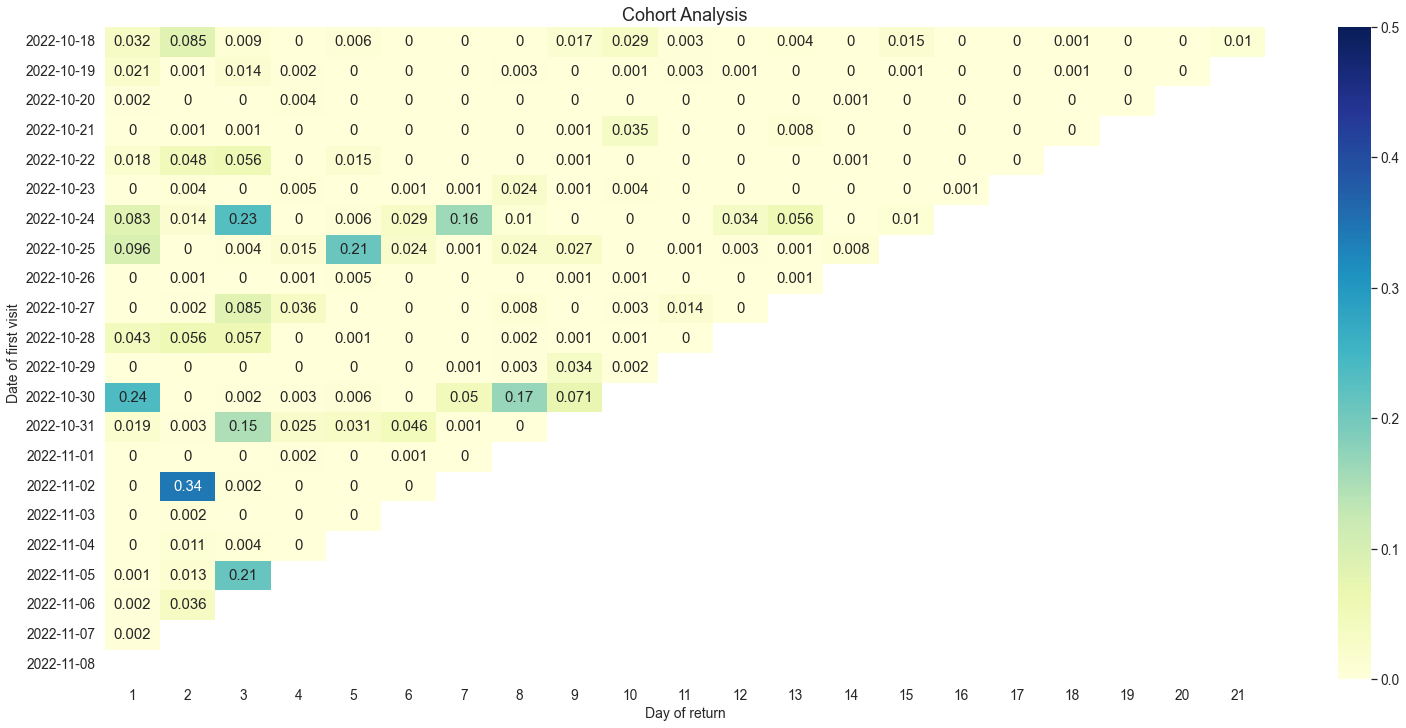

In [17]:
p_values = z_proportions_for_retention(ret_ads, ret_organic)

Финальный вопрос: отличается ли характер использования приложения у этих групп пользователей?

**Ответ**: да, отличается. По всей видимости, льется много нецелевого трафика и рекламные пользователи не удерживаются в приложении.